In [1]:
import sys, os, datetime, time
import numpy as np
import pandas as pd
import numpy.ma as ma
import math
import matplotlib.dates as dates
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from scipy.stats import norm
from scipy import stats
import matplotlib.pyplot as pylab
from matplotlib.dates import date2num, num2date 
from matplotlib.pyplot import figure, show

from matplotlib import rc

rc('font', **{'family': 'serif', 'serif': ['Times New Roman']},size=12.5)# 'Computer Modern'
rc('text', usetex=False)


In [2]:

# Enter file path for sim. and obs. flow files
simflowpath = 'C:/Users/ASUS/Desktop/data-carpentry/simu_flow_swat2.txt'
obsflowpath = 'C:/Users/ASUS/Desktop/data-carpentry/sim_obs_Iriga_cachi2.txt'
# Enter file path for observed precipitation files
precipfilepath = 'C:/Users/ASUS/Desktop/data-carpentry/prec.txt'

# Read flow sim and obs dates &  data
simflowdata = np.genfromtxt(simflowpath, usecols=[1])
obsflowdata = np.genfromtxt(obsflowpath, usecols=[1])
tempsimflowdate = np.genfromtxt(simflowpath, dtype = str, usecols = 0)
tempobsflowdate = np.genfromtxt(obsflowpath, dtype = str, usecols = 0)
# Read obs. precipitation data
precipdata = np.genfromtxt(precipfilepath, dtype = float, usecols = [1])
##############################################
# Convert the string format dates into a datetime object
simflowdate = []
for i in range(len(tempsimflowdate)):
    simflowdate.append(datetime.datetime.strptime(tempsimflowdate[i],'%m/%d/%Y'))
# sort the dates in an acending order
simflowdate.sort()

# Convert the string format dates into a datetime object
obsflowdate = []
for i in range(len(tempobsflowdate)):
    obsflowdate.append(datetime.datetime.strptime(tempobsflowdate[i],'%m/%d/%Y'))
# sort the dates in an acending order
obsflowdate.sort()

# Extraiga las fechas coincidentes de ambas matrices y márquelas por máscara
# searchsorted (t1, t2) encuentra el índice en t1 para cada valor en t2:    
idx_flow = np.searchsorted(simflowdate, obsflowdate, side='right')-1
j2 = [i for i in idx_flow if i > 0]

# enmascarar la matriz como verdadera si 
mask_flow = idx_flow >=0

# compare the obs. and sim. time series
df = pd.DataFrame({"simflowdate":tempsimflowdate[idx_flow][mask_flow], "simflow":simflowdata[idx_flow][mask_flow], \
                   "obsflow":obsflowdata[mask_flow], "obsflowdate":tempobsflowdate[mask_flow]})
    
    
# average of sim
sim_mean= sum(simflowdata[idx_flow][mask_flow])/float(len(simflowdata[idx_flow][mask_flow]))
# average of obs
obs_mean= sum(obsflowdata[mask_flow])/float(len(obsflowdata[mask_flow]))
# total sum of squares 
ss_tot = sum((x-obs_mean)**2 for x in obsflowdata[mask_flow]) 
# sum of squares of residuals
ss_err = sum((y-x)**2 for y,x in zip(simflowdata[idx_flow][mask_flow],obsflowdata[mask_flow]))

nash_flow = 1 - (ss_err/ss_tot)
print ("nash_flow= ", nash_flow)

gradient, intercept, r_value, p_value, std_err = stats.linregress(simflowdata[idx_flow][mask_flow],obsflowdata[mask_flow])
print ("R-squared = ", r_value**2)
if gradient <= 1:
  adj_r2 = gradient * (r_value**2)
  print ("adj_r2 =", adj_r2)
if gradient > 1:
  adj_r2 = gradient**(-1) * (r_value**2)
  print ("adj_r2 =", adj_r2)
  
 ############################################################################## 
# reconstruct the date objects with matching dates only 
fdate=[]
for i in idx_flow:
  if i >= 0:
    fdate.append(datetime.datetime.strptime(tempsimflowdate[i],'%m/%d/%Y'))

ssim = pd.Series(simflowdata[idx_flow][mask_flow], index=fdate)
sobs = pd.Series(obsflowdata[mask_flow], index=fdate)

nash_flow=  0.597070619834998
R-squared =  0.5977757016593027
adj_r2 = 0.5811893210841622


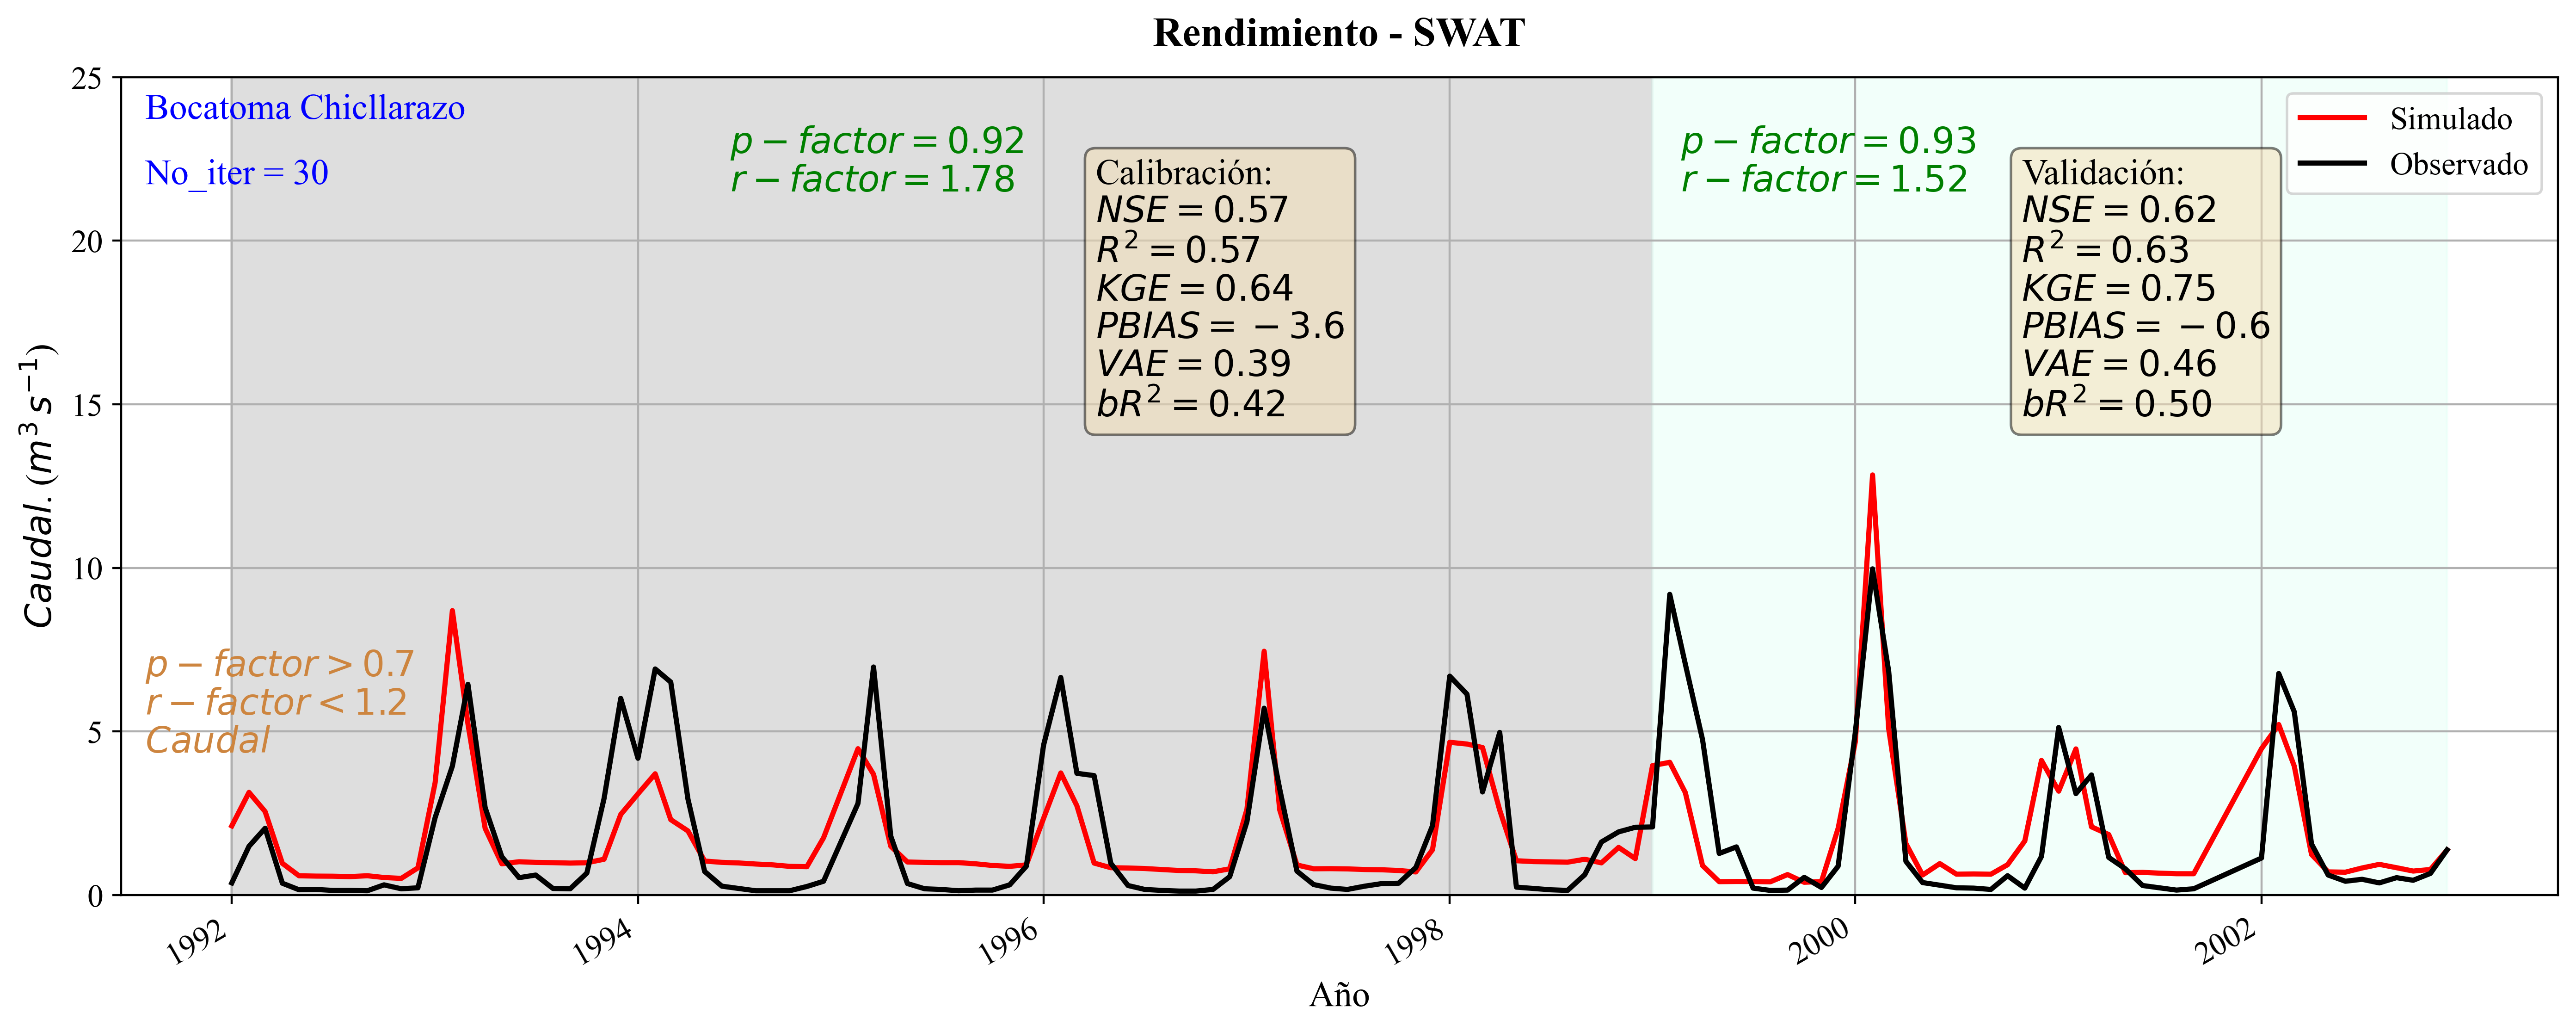

In [3]:
fig=plt.figure(figsize=(17,6.5),dpi=400)
ax = plt.subplot()
#fig.text(0.7, 0.8, r'$Nash=%.2f$' % nash_flow, fontsize=15)
plt.title('Rendimiento - SWAT', fontsize=16, y=1.02, fontweight='bold')
plt.ylabel('$Caudal$. ($m^{3}\,s^{-1}$)', fontsize=14)
plt.xlabel('Año', fontsize=14)


# s=square, -=dash, g^=triangle
#ssim['2009':'2016'].plot(label='Sim', color='red', linewidth=2.0)
#sobs['2009':'2016'].plot(label='Obs',color ='blue')
ssim['1992':'2002'].plot(label='Simulado', color ='red', linewidth=2)
sobs['1992':'2002'].plot(label='Observado', color ='black', linewidth=2)#sobs['2009':'2016'].plot(label='Obs', color ='black', linewidth=1, style='-o', markersize=5)


ax.grid(True)
#tight_layout()
ax.legend(loc='best')

calstartdate = datetime.datetime(1992,1,1)
calenddate = datetime.datetime(1998,12,31)   # CALIBRACION DATA
calstartdate1 = datetime.datetime(1999,1,1)
calenddate1 = datetime.datetime(2002,12,1)   # VALIDACION DATA
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
props1 = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
textstr1 = 'Calibración:\n$NSE = 0.57$\n$R^2 = 0.57$\n$KGE = 0.64$\n$PBIAS = -3.6$\n$VAE = 0.39$\n$bR^2 = 0.42$'
plt.text(0.4, 0.9, textstr1, fontsize=14, transform=ax.transAxes, verticalalignment='top', bbox=props)
textstr2 = 'Validación:\n$NSE = 0.62$\n$R^2 = 0.63$\n$KGE = 0.75$\n$PBIAS = -0.6$\n$VAE = 0.46$\n$bR^2 = 0.50$ '
plt.text(0.78, 0.9, textstr2, fontsize=14, transform=ax.transAxes, verticalalignment='top', bbox=props1)
textstr3 = 'Bocatoma Chicllarazo'
plt.text(0.01, 0.98, textstr3, fontsize=14, transform=ax.transAxes, verticalalignment='top', color='blue')
textstr4 = 'No_iter = 30'
plt.text(0.01, 0.90, textstr4, fontsize=14, transform=ax.transAxes, verticalalignment='top', color='blue')
textstr5 = '\n$p-factor = 0.92$\n$r-factor = 1.78$'
plt.text(0.25, 0.99, textstr5, fontsize=14, transform=ax.transAxes, verticalalignment='top', color='green')
textstr6 = '\n$p-factor = 0.93$\n$r-factor = 1.52$'
plt.text(0.64, 0.99, textstr6, fontsize=14, transform=ax.transAxes, verticalalignment='top', color='green')
textstr7 = '\n$p-factor > 0.7$\n$r-factor < 1.2$\n$Caudal$'
plt.text(0.01, 0.35, textstr7, fontsize=14, transform=ax.transAxes, verticalalignment='top', color='peru')

threshold = 40
plt.ylim([0, 25])
ax.axvspan(calstartdate, calenddate, alpha=0.5, color='0.75')
ax.axvspan(calstartdate1, calenddate1, alpha=0.5, color='#e6fff7')
plt.show()

#plt.savefig('C:/Users/ASUS/Desktop/data-carpentry/calib_valid4.png', dpi=300, bbox_inches='tight')

nash_flow=  0.597070619834998
R-squared =  0.5977757016593027
adj_r2 = 0.5811893210841622


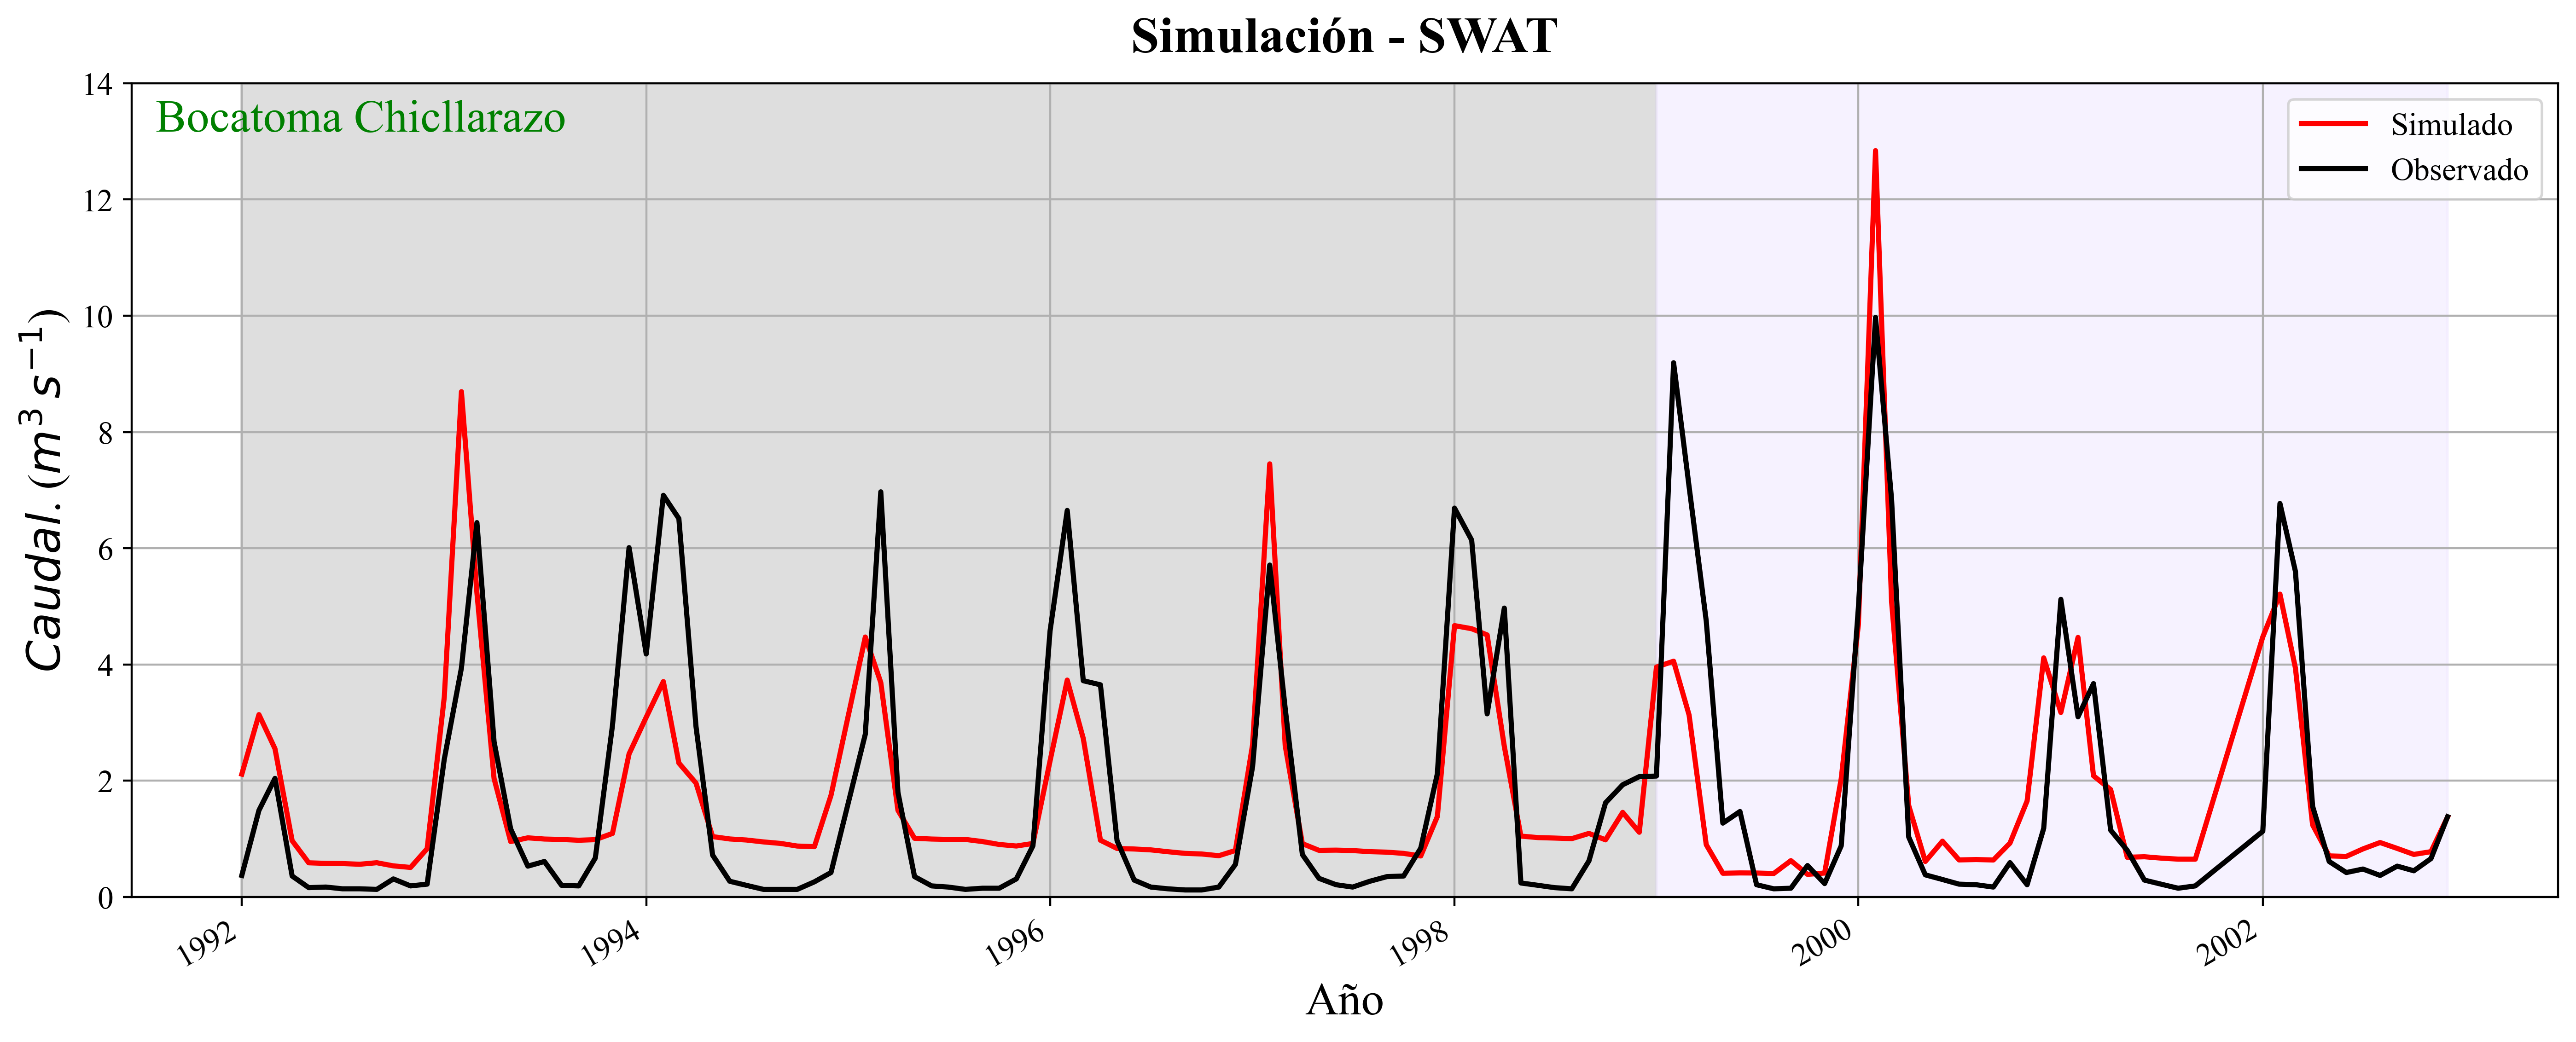

In [4]:
simflowpath = 'C:/Users/ASUS/Desktop/data-carpentry/simu_flow_swat2.txt'
obsflowpath = 'C:/Users/ASUS/Desktop/data-carpentry/sim_obs_Iriga_cachi2.txt'
# Enter file path for observed precipitation files
precipfilepath = 'C:/Users/ASUS/Desktop/data-carpentry/prec.txt'

# Read flow sim and obs dates &  data
simflowdata = np.genfromtxt(simflowpath, usecols=[1])
obsflowdata = np.genfromtxt(obsflowpath, usecols=[1])
tempsimflowdate = np.genfromtxt(simflowpath, dtype = str, usecols = 0)
tempobsflowdate = np.genfromtxt(obsflowpath, dtype = str, usecols = 0)
# Read obs. precipitation data
precipdata = np.genfromtxt(precipfilepath, dtype = float, usecols = [1])
##############################################
# Convert the string format dates into a datetime object
simflowdate = []
for i in range(len(tempsimflowdate)):
    simflowdate.append(datetime.datetime.strptime(tempsimflowdate[i],'%m/%d/%Y'))
# sort the dates in an acending order
simflowdate.sort()

# Convert the string format dates into a datetime object
obsflowdate = []
for i in range(len(tempobsflowdate)):
    obsflowdate.append(datetime.datetime.strptime(tempobsflowdate[i],'%m/%d/%Y'))
# sort the dates in an acending order
obsflowdate.sort()

# Extraiga las fechas coincidentes de ambas matrices y márquelas por máscara
# searchsorted (t1, t2) encuentra el índice en t1 para cada valor en t2:    
idx_flow = np.searchsorted(simflowdate, obsflowdate, side='right')-1
j2 = [i for i in idx_flow if i > 0]

# enmascarar la matriz como verdadera si 
mask_flow = idx_flow >=0

# compare the obs. and sim. time series
df = pd.DataFrame({"simflowdate":tempsimflowdate[idx_flow][mask_flow], "simflow":simflowdata[idx_flow][mask_flow], \
                   "obsflow":obsflowdata[mask_flow], "obsflowdate":tempobsflowdate[mask_flow]})
    
    
# average of sim
sim_mean= sum(simflowdata[idx_flow][mask_flow])/float(len(simflowdata[idx_flow][mask_flow]))
# average of obs
obs_mean= sum(obsflowdata[mask_flow])/float(len(obsflowdata[mask_flow]))
# total sum of squares 
ss_tot = sum((x-obs_mean)**2 for x in obsflowdata[mask_flow]) 
# sum of squares of residuals
ss_err = sum((y-x)**2 for y,x in zip(simflowdata[idx_flow][mask_flow],obsflowdata[mask_flow]))

nash_flow = 1 - (ss_err/ss_tot)
print ("nash_flow= ", nash_flow)

gradient, intercept, r_value, p_value, std_err = stats.linregress(simflowdata[idx_flow][mask_flow],obsflowdata[mask_flow])
print ("R-squared = ", r_value**2)
if gradient <= 1:
  adj_r2 = gradient * (r_value**2)
  print ("adj_r2 =", adj_r2)
if gradient > 1:
  adj_r2 = gradient**(-1) * (r_value**2)
  print ("adj_r2 =", adj_r2)
  
 ############################################################################## 
# reconstruct the date objects with matching dates only 
fdate=[]
for i in idx_flow:
  if i >= 0:
    fdate.append(datetime.datetime.strptime(tempsimflowdate[i],'%m/%d/%Y'))

ssim = pd.Series(simflowdata[idx_flow][mask_flow], index=fdate)
sobs = pd.Series(obsflowdata[mask_flow], index=fdate)

fig=plt.figure(figsize=(17,6.5),dpi=400)
ax = plt.subplot()
#fig.text(0.7, 0.8, r'$Nash=%.2f$' % nash_flow, fontsize=15)
plt.title('Simulación - SWAT', fontsize=20, y=1.02, fontweight='bold')
plt.ylabel('$Caudal$. ($m^{3}\,s^{-1}$)', fontsize=18.)
plt.xlabel('Año', fontsize=18.)
# s=square, -=dash, g^=triangle
#ssim['2009':'2016'].plot(label='Sim', color='red', linewidth=2.0)
#sobs['2009':'2016'].plot(label='Obs',color ='blue')
ssim['1992':'2002'].plot(label='Simulado', color ='red', linewidth=2)
sobs['1992':'2002'].plot(label='Observado', color ='black', linewidth=2)#sobs['2009':'2016'].plot(label='Obs', color ='black', linewidth=1, style='-o', markersize=5)

ax.grid(True)
#tight_layout()
ax.legend(loc='best')

calstartdate = datetime.datetime(1992,1,1)
calenddate = datetime.datetime(1998,12,31)   # CALIBRACION DATA
calstartdate1 = datetime.datetime(1999,1,1)
calenddate1 = datetime.datetime(2002,12,1)   # VALIDACION DATA
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
props1 = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
textstr3 = 'Bocatoma Chicllarazo'
plt.text(0.01, 0.98, textstr3, fontsize=18, transform=ax.transAxes, verticalalignment='top', color='green')
threshold = 40
plt.ylim([0, 14])
ax.axvspan(calstartdate, calenddate, alpha=0.5, color='0.75')
ax.axvspan(calstartdate1, calenddate1, alpha=0.5, color='#efe6ff')
plt.show()